# DonorsChoose.org Application Screening

https://www.kaggle.com/c/donorschoose-application-screening

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
df_train = pd.read_csv("E:/Python Stuff/donorschoose-application-screening/train.csv")

1. id - unique id of the project application
2. teacher_id - id of the teacher submitting the application
3. teacher_prefix - title of the teacher's name (Ms., Mr., etc.)
4. school_state - US state of the teacher's school
5. project_submitted_datetime - application submission timestamp
6. project_grade_category - school grade levels (PreK-2, 3-5, 6-8, and 9-12)
7. project_subject_categories - category of the project (e.g., "Music & The Arts")
8. project_subject_subcategories - sub-category of the project (e.g., "Visual Arts")
9. project_title - title of the project
10. project_essay_1 - Introduce us to your classroom / Describe your students
11. project_essay_2 - Tell us more about your students / About your project
12. project_essay_3 - Describe how your students will use the materials you're requesting
13. project_essay_4 - Close by sharing why your project will make a difference
14. project_resource_summary - summary of the resources needed for the project
15. teacher_number_of_previously_posted_projects - number of previously posted applications by the submitting teacher
16. project_is_approved - whether DonorsChoose proposal was accepted (0="rejected", 1="accepted")

In [4]:
df_train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [5]:
print("number of rows:", len(df_train))
df_train.isna().sum()

number of rows: 182080


id                                                   0
teacher_id                                           0
teacher_prefix                                       4
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 175706
project_essay_4                                 175706
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [6]:
df_train["teacher_prefix"].value_counts()

Mrs.       95405
Ms.        65066
Mr.        17667
Teacher     3912
Dr.           26
Name: teacher_prefix, dtype: int64

In [7]:
# fillna
df_train["teacher_prefix"].fillna("Mrs.", inplace=True)
df_train["project_essay_3"].fillna(" ", inplace=True)
df_train["project_essay_4"].fillna(" ", inplace=True)

In [8]:
df_train["comment"] = df_train["project_title"]+" "+df_train["project_essay_1"]+" "+df_train["project_essay_2"]+" "+df_train["project_essay_3"]+" "+df_train["project_essay_4"]+" "+df_train["project_resource_summary"]

In [9]:
# datetime
df_train["project_submitted_datetime"] = pd.to_datetime(df_train["project_submitted_datetime"])
df_train['date_month'] = df_train['project_submitted_datetime'].dt.month
df_train['date_dayofweek'] = df_train['project_submitted_datetime'].dt.dayofweek

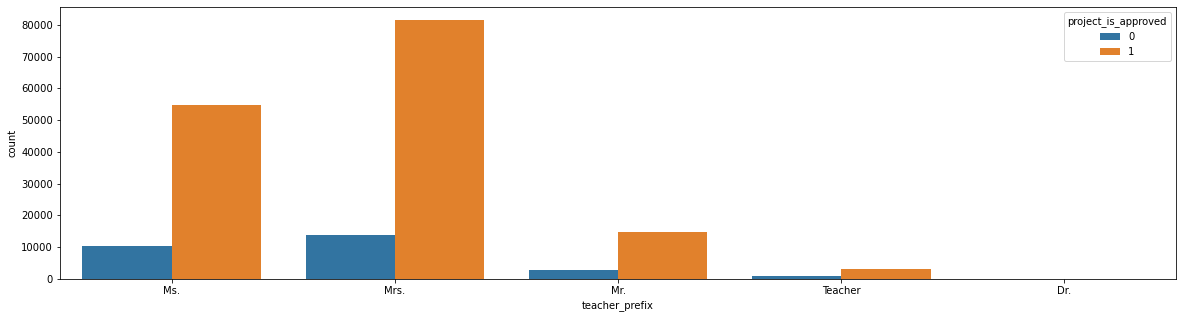

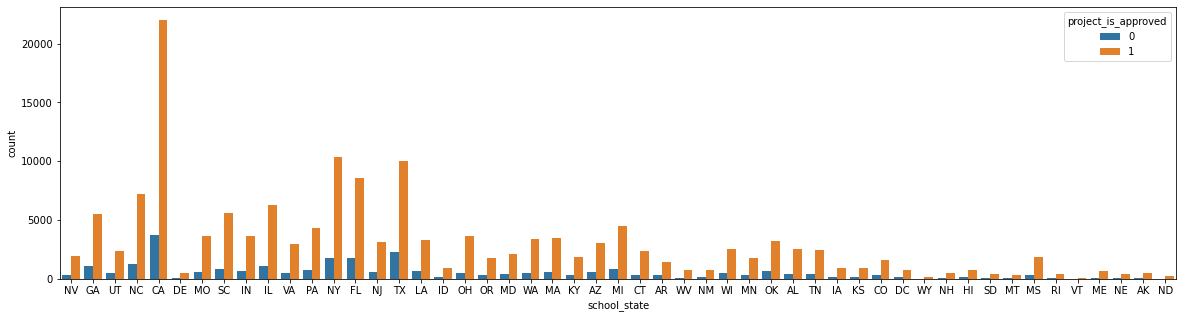

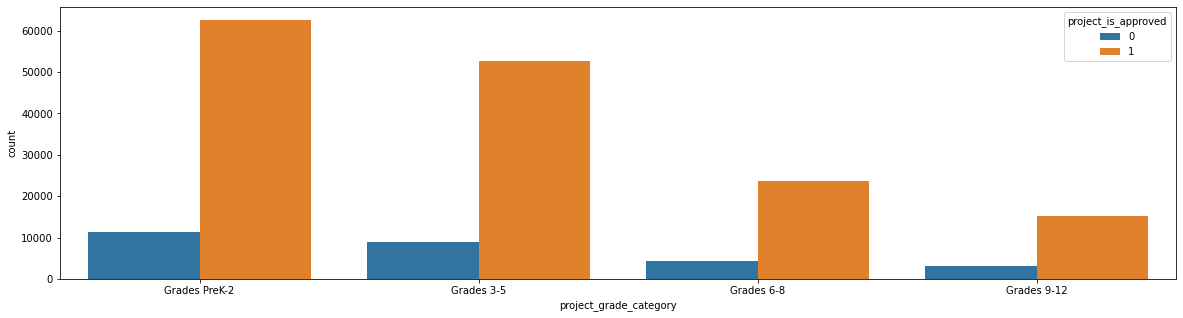

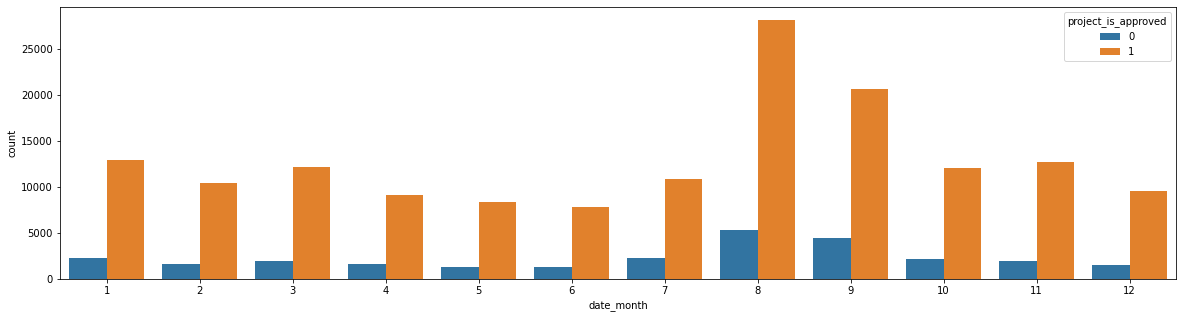

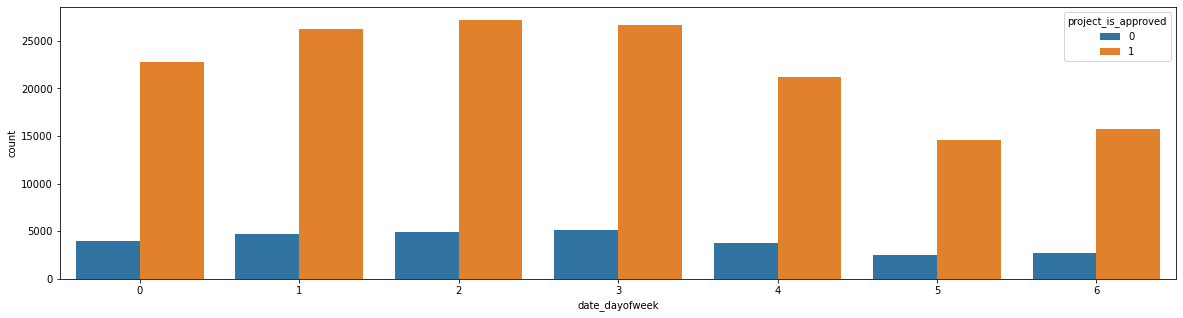

In [10]:
cat_col = ['teacher_prefix', 'school_state', 'project_grade_category', 'date_month', 'date_dayofweek']
for col in cat_col:
    plt.figure(figsize=(20, 5))
    sns.countplot(x=col, hue="project_is_approved", data=df_train)
    plt.show()

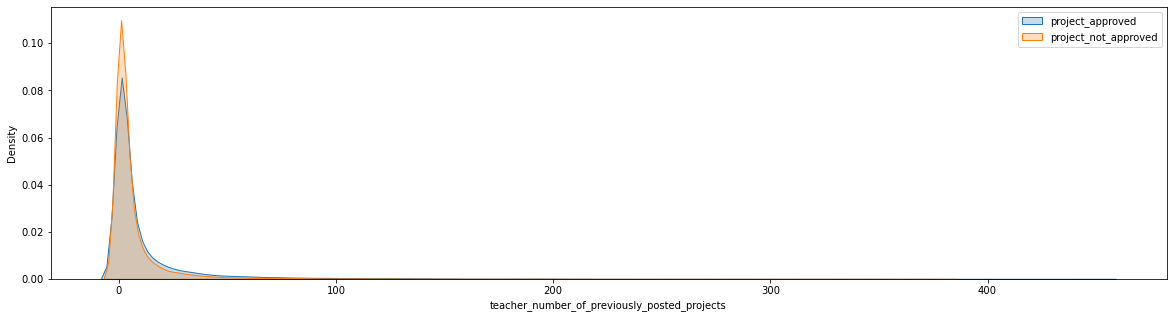

In [11]:
plt.figure(figsize=(20, 5))
sns.kdeplot(data=df_train[df_train["project_is_approved"]==1]['teacher_number_of_previously_posted_projects'], shade=True)
sns.kdeplot(data=df_train[df_train["project_is_approved"]==0]['teacher_number_of_previously_posted_projects'], shade=True)
plt.legend(labels=['project_approved','project_not_approved'])
plt.show()
#teacher_number_of_previously_posted_projects

In [12]:
# project_subject_categories: 2 or more categories may be in the same cell, need to be split and then one hot encoding
for row in range(len(df_train)):
    text = df_train.loc[row,"project_subject_categories"]
    for cat in text.split(", "):
        if "cat_{}".format(cat) not in df_train.columns:
            df_train["cat_{}".format(cat)] = 0
        df_train.loc[row,"cat_{}".format(cat)] = 1

In [13]:
# project_subject_subcategories: 2 or more subcategories may be in the same cell, need to be split and then one hot encoding
for row in range(len(df_train)):
    text = df_train.loc[row,"project_subject_subcategories"]
    for subcat in text.split(", "):
        if "subcat_{}".format(subcat) not in df_train.columns:
            df_train["subcat_{}".format(subcat)] = 0
        df_train.loc[row,"subcat_{}".format(subcat)] = 1

In [14]:
# label encoding for category feature columns
for col in cat_col:
    le = LabelEncoder()
    df_train["{}_encoded".format(col)] = le.fit_transform(df_train[col])

In [15]:
X = df_train.drop(columns=['id', 'teacher_id', 'project_submitted_datetime', 'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4', 'project_resource_summary',
        'teacher_prefix', 'school_state', 'project_grade_category', 'date_month', 'date_dayofweek','project_is_approved'])
y = df_train['project_is_approved']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
# Prepare LancasterStemmer
stopword = stopwords.words("english")
lancaster = LancasterStemmer()
tokenizer = nltk.RegexpTokenizer('[a-z]\w+')
def stemming_tokenizer(sentence):
    token_words_with_stopword = tokenizer.tokenize(sentence.lower())
    token_words = [token for token in token_words_with_stopword if token not in stopword]
    words = [lancaster.stem(word) for word in token_words]
    return words

In [18]:
# Tfidf Vectorizer
vec = TfidfVectorizer(tokenizer=stemming_tokenizer,
                      use_idf=False,
                      max_df=0.85, max_features=4000
                     )
matrix_train = vec.fit_transform(X_train["comment"])
df_train_tfidf = pd.DataFrame(matrix_train.toarray(), columns=vec.get_feature_names(), index=X_train.index)

In [19]:
df_train_tfidf.head()

,ab,abc,abl,abs,absolv,absorb,abstract,abund,abus,ac,academ,academy,acc,acceiv,accel,access,accid,accommod,accompany,accompl,accord,account,accum,accustom,achiev,...,xylophon,yard,yarn,ye,year,yearbook,yearn,yellow,yesterday,yet,yield,yog,york,you,young,youngest,youngst,youtub,zenergy,zero,zest,zip,zon,zoo,zoom
149561,0.0,0.0,0.116052,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.058026,0.0,0.0,0.0,0.0,0.116052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.058026,0.0,0.0,0.0,0.0
106150,0.0,0.0,0.120605,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.060302,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.060302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060302,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
84293,0.0,0.0,0.058824,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.117647,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
174128,0.0,0.0,0.072739,0.0,0.072739,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
114111,0.0,0.0,0.207950,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.103975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [20]:
X_train = pd.merge(X_train, df_train_tfidf, left_index=True, right_index=True)

In [21]:
matrix_test = vec.transform(X_test["comment"])
df_test_tfidf = pd.DataFrame(matrix_test.toarray(), columns=vec.get_feature_names(), index=X_test.index)
X_test = pd.merge(X_test,df_test_tfidf, left_index=True, right_index=True)

In [22]:
X_train.drop(columns="comment", inplace=True)
X_test.drop(columns="comment", inplace=True)

In [23]:
categorical_feature = ["{}_encoded".format(col) for col in cat_col]

In [24]:
train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False, categorical_feature=categorical_feature)
test_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False, categorical_feature=categorical_feature)

In [25]:
params = {'objective':'binary', "metric":"auc","learning_rate":0.001, "num_round":10000}

In [26]:
evaluation_results = {}
clf = lgb.train(train_set=train_data,
                 params=params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 verbose_eval=2000
                )

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 115770, number of negative: 20790
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.960328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639709
[LightGBM] [Info] Number of data points in the train set: 136560, number of used features: 4045


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.847759 -> initscore=1.717133
[LightGBM] [Info] Start training from score 1.717133
[2000]	Train's auc: 0.723566	Test's auc: 0.700639
[4000]	Train's auc: 0.758053	Test's auc: 0.720238
[6000]	Train's auc: 0.779494	Test's auc: 0.730429
[8000]	Train's auc: 0.796154	Test's auc: 0.736087
[10000]	Train's auc: 0.810546	Test's auc: 0.738928


In [27]:
y_test_hat = clf.predict(X_test)

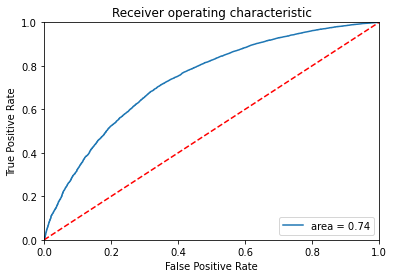

In [28]:
auroc = roc_auc_score(y_test, y_test_hat)
fpr, tpr, thresholds = roc_curve(y_test, y_test_hat)
plt.figure()
plt.plot(fpr, tpr, label='area = %0.2f' % auroc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
cm = confusion_matrix(y_test, y_test_hat.round())
print(cm)

[[  140  6804]
 [   80 38496]]
